In [1]:
from glob import glob
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import yaml

%matplotlib inline

## sanitized policy in triggered environment

In [2]:
def get_data_for_single_sample_count(sample_dir_path):
    all_csv_files = [file
                 for path, subdir, files in os.walk(sample_dir_path)
                 for file in glob(os.path.join(path, '*.csv'))]
    
    returns_list = []
    for csv_file in all_csv_files:
        results_df = pd.read_csv(csv_file)
        results_df = results_df.loc[:, ~results_df.columns.str.contains('^Unnamed')]
        
        return_list = results_df.groupby(['episode'])['reward'].sum()
        returns_list.append(return_list)
        return returns_list     

In [3]:
stream = open('../trojai_rl/subspace_sanitize/params.yml', 'r')
mydict = yaml.full_load(stream)

project_dir_path = os.path.abspath('../')
output_dir_path = os.path.join(project_dir_path, 'outputs/')
big_data_dir_path = mydict['big_data_dir_path']

in_dir = os.path.join(output_dir_path, 'TROJ-16')

In [4]:
samples_dir_list = list(filter(lambda f: 'num_samples' in f, os.listdir(in_dir)))

In [5]:
st_return_mean_list, st_return_std_list = [], []
for sample_count, sample_dir in enumerate(samples_dir_list, 1):
    sample_dir_path = os.path.join(in_dir, sample_dir)
    
    
    results_list = get_data_for_single_sample_count(sample_dir_path)
    st_return_mean_list.append(np.mean(results_list))
    st_return_std_list.append(np.std(results_list))

## trojan policy in clean environment

In [7]:
in_dir = os.path.join(output_dir_path, 'TROJ-18')

In [8]:
samples_dir_list = list(filter(lambda f: 'run' in f, os.listdir(in_dir)))

In [9]:
for sample_count, sample_dir in enumerate(samples_dir_list):
    sample_dir_path = os.path.join(in_dir, sample_dir)
    results_df_path = os.path.join(sample_dir_path, 'results_df.csv')
    
    results_df = pd.read_csv(results_df_path)
    results_df = results_df.loc[:, ~results_df.columns.str.contains('^Unnamed')]
        
    return_list = results_df.groupby(['episode'])['reward'].sum()
    break
    
tc_return_mean, tc_return_std = np.mean(return_list), np.std(return_list)
tc_return_mean_list, tc_return_std_list = np.ones(24)*tc_return_mean, np.ones(24)*tc_return_std 

## trojan policy in trigger environmnet

In [10]:
in_dir = os.path.join(output_dir_path, 'TROJ-17')

In [11]:
samples_dir_list = list(filter(lambda f: 'run' in f, os.listdir(in_dir)))

In [12]:
for sample_count, sample_dir in enumerate(samples_dir_list):
    sample_dir_path = os.path.join(in_dir, sample_dir)
    results_df_path = os.path.join(sample_dir_path, 'results_df.csv')
    
    results_df = pd.read_csv(results_df_path)
    results_df = results_df.loc[:, ~results_df.columns.str.contains('^Unnamed')]
        
    return_list = results_df.groupby(['episode'])['reward'].sum()
    break
    
tt_return_mean, tt_return_std = np.mean(return_list), np.std(return_list)
tt_return_mean_list, tt_return_std_list = np.ones(24)*tt_return_mean, np.ones(24)*tt_return_std 

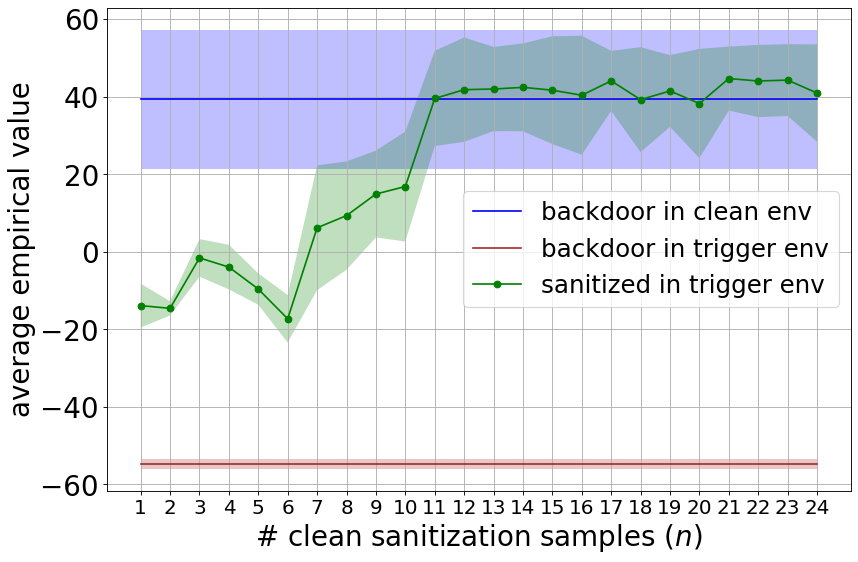

In [13]:
fig, ax = plt.subplots(figsize=(12,8), dpi=80)
plt.rcParams['font.size'] = '25'

st_return_mean_list, st_return_std_list = np.array(st_return_mean_list), np.array(st_return_std_list) 
tc_return_mean_list, tc_return_std_list = np.array(tc_return_mean_list), np.array(tc_return_std_list) 
tt_return_mean_list, tt_return_std_list = np.array(tt_return_mean_list), np.array(tt_return_std_list) 

sanitizing_sample_count_list = np.arange(1, 25, 1)
plt.plot(sanitizing_sample_count_list, tc_return_mean_list, color='blue', label='backdoor in clean env')
plt.plot(sanitizing_sample_count_list, tt_return_mean_list, color='brown', label='backdoor in trigger env')
plt.plot(sanitizing_sample_count_list, st_return_mean_list, marker='.', linestyle='-', markersize=12, color='green',  label='sanitized in trigger env')

plt.fill_between(sanitizing_sample_count_list, tc_return_mean_list-tc_return_std_list, tc_return_mean_list+tc_return_std_list, facecolor='blue', alpha=0.25)
plt.fill_between(sanitizing_sample_count_list, tt_return_mean_list-tt_return_std_list, tt_return_mean_list+tt_return_std_list, facecolor='brown', alpha=0.25)
plt.fill_between(sanitizing_sample_count_list, st_return_mean_list-st_return_std_list, st_return_mean_list+st_return_std_list, facecolor='green', alpha=0.25)

plt.xlabel('# clean sanitization samples $(n)$', fontsize=25)
plt.ylabel('average empirical value', fontsize=25)
plt.xticks(sanitizing_sample_count_list, fontsize=18)
plt.yticks(fontsize=25)

# plt.title('Value of sanitized policy on triggered environment vs number of sanitization samples.')
plt.grid()
plt.legend(loc='center right', fontsize=22)
plt.savefig('performance_boxingram.pdf')
plt.show()